# FX Leverage Carry-Trade

In [21]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import carry_trade as ct
import datetime as dt

from date_function_v2 import holiday_adjust

matplotlib.rcParams[ 'figure.figsize' ] = ( 16, 9 )

## 1. Load data

In [2]:
data_path_new = 'Final_Data/to_send.csv'
final_data_new = pd.read_csv(data_path_new)

In [3]:
final_data_new = final_data_new.set_index('Date')
final_data_new.index = pd.to_datetime(final_data_new.index)

In [49]:
final_data_new.iloc[324:]

,Unnamed: 0,GBP_Spot,GBP_1W,GBP_1M,GBP_2M,GBP_LIBOR_1W,GBP_LIBOR_1M,GBP_LIBOR_2M,AUD_Spot,AUD_1M,...,USD_LIBOR_2M,JPY_LIBOR_1W,JPY_LIBOR_1M,JPY_LIBOR_2M,JPY_USD_Bid,JPY_USD_Ask,JPY_GBP_Bid,JPY_GBP_Ask,JPY_AUD_Bid,JPY_AUD_Ask
Date,,,,,,,,,,,,,,,,,,,,,
2009-01-02,324,133.563,133.5147,133.3877,133.2398,2.00875,2.11375,2.50500,65.330,65.0853,...,1.09875,0.44375,0.67125,0.75625,91.77,91.90,133.375,133.750,65.250,65.410
2009-01-05,325,137.348,137.3121,137.2043,137.0200,2.00000,2.05750,2.44500,67.040,66.8083,...,1.09750,0.41000,0.62000,0.73875,93.38,93.50,137.230,137.465,66.970,67.110
2009-01-06,326,139.690,139.6514,139.5436,139.4050,2.00000,2.02250,2.40875,67.730,67.4995,...,1.09125,0.39875,0.60625,0.71875,93.63,93.67,139.600,139.780,67.699,67.760
2009-01-07,327,139.850,139.8184,139.7247,139.5852,1.98750,1.99625,2.36750,66.020,65.7923,...,1.07250,0.39375,0.58625,0.70750,92.62,92.68,139.740,139.960,65.980,66.060
2009-01-08,328,138.773,138.7393,138.6363,138.5097,1.75000,1.92750,2.30375,64.948,64.7275,...,1.03750,0.38625,0.56250,0.69375,91.17,91.24,138.680,138.865,64.900,64.995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11-05,3032,140.636,140.6122,140.5222,140.3411,0.68888,0.71588,0.76400,75.247,75.1769,...,1.85463,-0.11183,-0.10200,-0.09650,109.14,109.17,140.566,140.706,75.233,75.261
2019-11-06,3033,140.089,140.0652,139.9804,139.7962,0.69125,0.71663,0.76325,75.024,74.9555,...,1.84525,-0.08667,-0.08717,-0.09350,108.96,108.99,140.026,140.152,75.008,75.040
2019-11-07,3034,140.090,140.0657,139.9853,139.7794,0.68938,0.71725,0.76138,75.385,75.3188,...,1.84675,-0.07400,-0.09800,-0.10383,109.27,109.30,139.858,140.322,75.369,75.401


## 2. Implement Strategy 

In [5]:
# if you want to test single currency or single trading period, just modify the following list
fx_list = ['USD', 'AUD', 'GBP']
period_list = [7, 30, 60]

In [6]:
# idx, row_row = next(final_data.iterrows())
# ct.find_max_signal(row_row, period_list, fx_list)

In [11]:
results_07 = ct.algo_loop(final_data_new, fx_list, period_list, leverage = 2.0)
results_09 = ct.algo_loop(final_data_new.iloc[324:], fx_list, period_list, leverage = 2.0)

2019-11-18 16:01:33:568141: Beginning Carry-Trade Strategy run
2019-11-18 16:01:49:216623: Algo run complete.
2019-11-18 16:01:49:217110: Beginning Carry-Trade Strategy run
2019-11-18 16:02:03:294513: Algo run complete.


In [12]:
results_07

,Signal,FX_name,Period,Foreign_IR,Domestic_IR,FX_Rate,Equity,Asset Pos,Unreal_Return,Real_Return
Date,,,,,,,,,,
2007-09-21,0.000259552,GBP,1M,0.0626375,0.0085625,233.345,10000,20000,0.00877853,0
2007-09-24,0.000259552,GBP,1M,0.0625,0.008525,232.275,10000,20000,-0.000371674,0
2007-09-25,0.000259552,GBP,1M,0.062375,0.008525,231.705,10000,20000,-0.00521597,0
2007-09-26,0.000259552,GBP,1M,0.06205,0.0085125,232.94,10000,20000,0.00532565,0
2007-09-27,0.000259552,GBP,1M,0.061925,0.0085,234.453,10000,20000,0.0183549,0
...,...,...,...,...,...,...,...,...,...,...
2019-11-05,5.13588e-05,AUD,2M,0.0092,-0.000965,75.247,6414.05,12828.1,0.0857553,-0.358595
2019-11-06,5.13588e-05,AUD,2M,0.0093,-0.000935,75.024,6414.05,12828.1,0.0795475,-0.358595
2019-11-07,5.13588e-05,AUD,2M,0.009183,-0.0010383,75.385,6414.05,12828.1,0.0895318,-0.358595


In [14]:
results_07.to_csv('Results/results_07.csv')
results_09.to_csv('Results/results_09.csv')

In [15]:
# if you want to test single currency or single trading period, just modify the following list
usd_list = ['USD']
aud_list = ['AUD']
gbp_list = ['GBP']

In [16]:
results_usd = ct.algo_loop(final_data_new.iloc[324:], usd_list, period_list, leverage = 2.0)
results_aud = ct.algo_loop(final_data_new.iloc[324:], aud_list, period_list, leverage = 2.0)
results_gbp = ct.algo_loop(final_data_new.iloc[324:], gbp_list, period_list, leverage = 2.0)

2019-11-18 16:02:45:017303: Beginning Carry-Trade Strategy run
2019-11-18 16:02:55:649949: Algo run complete.
2019-11-18 16:02:55:650726: Beginning Carry-Trade Strategy run
2019-11-18 16:03:02:137468: Algo run complete.
2019-11-18 16:03:02:137955: Beginning Carry-Trade Strategy run
2019-11-18 16:03:10:300936: Algo run complete.


In [17]:
results_usd.to_csv('Results/results_usd_09.csv')
results_usd

,Signal,FX_name,Period,Foreign_IR,Domestic_IR,FX_Rate,Equity,Asset Pos,Unreal_Return,Real_Return
Date,,,,,,,,,,
2009-01-02,-0.000176637,-,-,0,0,1,10000,0,0,0
2009-01-05,-6.6144e-05,-,-,0,0,1,10000,0,0,0
2009-01-06,-9.01668e-05,-,-,0,0,1,10000,0,0,0
2009-01-07,-5.37706e-05,-,-,0,0,1,10000,0,0,0
2009-01-08,-3.8818e-05,-,-,0,0,1,10000,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2019-11-05,-3.22445e-05,-,-,0,0,1,10153.3,0,0,0.0153328
2019-11-06,-3.75076e-05,-,-,0,0,1,10153.3,0,0,0.0153328
2019-11-07,-4.07196e-05,-,-,0,0,1,10153.3,0,0,0.0153328


In [18]:
results_aud.to_csv('Results/results_aud_09.csv')
results_aud

,Signal,FX_name,Period,Foreign_IR,Domestic_IR,FX_Rate,Equity,Asset Pos,Unreal_Return,Real_Return
Date,,,,,,,,,,
2009-01-02,4.26045e-05,AUD,2M,0.047875,0.0075625,65.33,10000,20000,0.00976666,0
2009-01-05,4.26045e-05,AUD,2M,0.0475,0.0073875,67.04,10000,20000,0.0626788,0
2009-01-06,4.26045e-05,AUD,2M,0.047,0.0071875,67.73,10000,20000,0.0850063,0
2009-01-07,4.26045e-05,AUD,2M,0.047125,0.007075,66.02,10000,20000,0.0320946,0
2009-01-08,4.26045e-05,AUD,2M,0.046375,0.0069375,64.948,10000,20000,-0.00141239,0
...,...,...,...,...,...,...,...,...,...,...
2019-11-05,5.13588e-05,AUD,2M,0.0092,-0.000965,75.247,13883.6,27767.3,0.0857553,0.388365
2019-11-06,5.13588e-05,AUD,2M,0.0093,-0.000935,75.024,13883.6,27767.3,0.0795475,0.388365
2019-11-07,5.13588e-05,AUD,2M,0.009183,-0.0010383,75.385,13883.6,27767.3,0.0895318,0.388365


In [19]:
results_gbp.to_csv('Results/results_gbp_09.csv')
results_gbp

,Signal,FX_name,Period,Foreign_IR,Domestic_IR,FX_Rate,Equity,Asset Pos,Unreal_Return,Real_Return
Date,,,,,,,,,,
2009-01-02,0.000484649,GBP,2M,0.02505,0.0075625,133.563,10000,20000,0.0014587,0
2009-01-05,0.000484649,GBP,2M,0.02445,0.0073875,137.348,10000,20000,0.0591682,0
2009-01-06,0.000484649,GBP,2M,0.0240875,0.0071875,139.69,10000,20000,0.0946591,0
2009-01-07,0.000484649,GBP,2M,0.023675,0.007075,139.85,10000,20000,0.096636,0
2009-01-08,0.000484649,GBP,2M,0.0230375,0.0069375,138.773,10000,20000,0.0805256,0
...,...,...,...,...,...,...,...,...,...,...
2019-11-05,-1.35603e-05,-,-,0,0,1,13234.3,0,0,0.323435
2019-11-06,-1.86526e-05,-,-,0,0,1,13234.3,0,0,0.323435
2019-11-07,-2.50482e-05,-,-,0,0,1,13234.3,0,0,0.323435


## 3. Analysis 

## 3.1 After Crisis
[USD, GBP, AUD]

put in one time series graph: [USD], [GBP], [AUD]



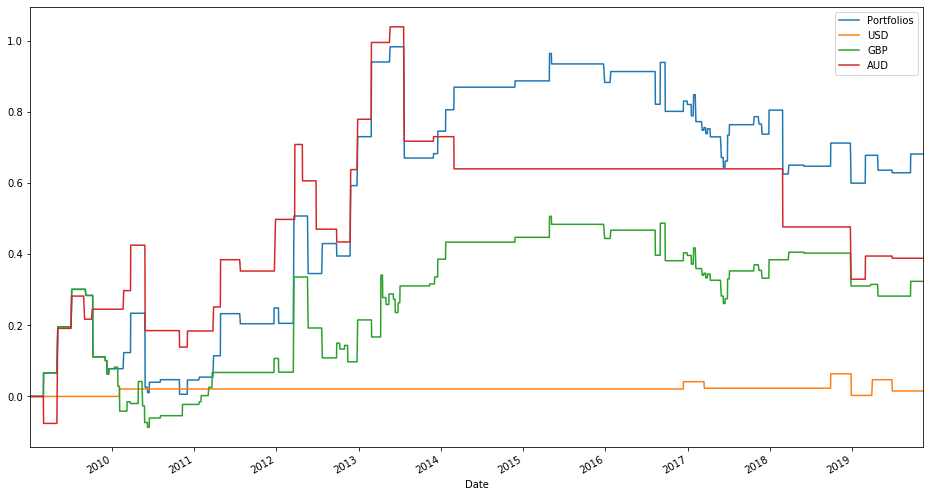

In [23]:
results_09['Real_Return'].plot(label='Portfolios')
results_usd['Real_Return'].plot(label='USD')
results_gbp['Real_Return'].plot(label='GBP')
results_aud['Real_Return'].plot(label='AUD')
plt.legend()
plt.show()

### 3.1.1 Realized Return Time Series

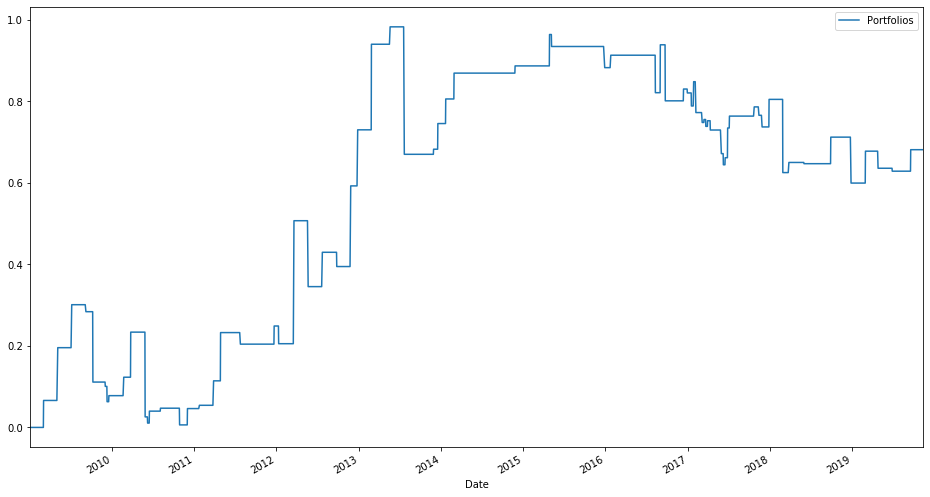

In [26]:
results_09['Real_Return'].plot(label='Portfolios')
plt.legend()
plt.show()

### 3.1.2 Realized Return Histogram

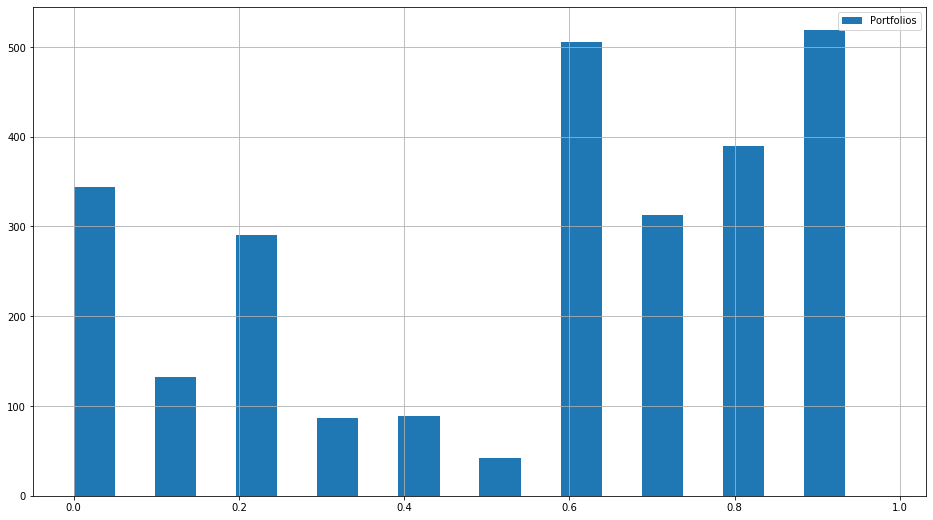

In [28]:
results_09['Real_Return'].hist(width=0.05, label='Portfolios')
plt.legend()
plt.show()

### 3.1.3 Unrealized Return Histogram

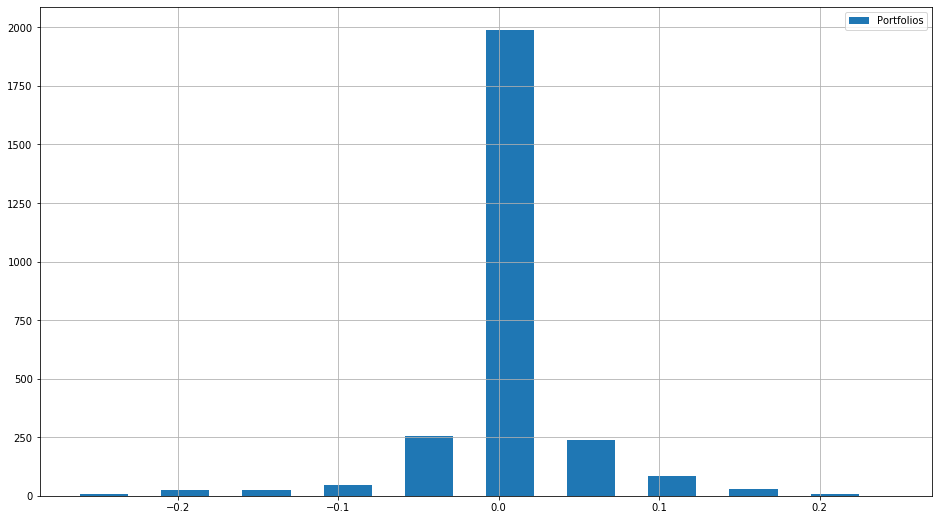

In [32]:
results_09['Unreal_Return'].hist(width=0.03, label='Portfolios')
plt.legend()
plt.show()

### 3.1.4 Value at Risk

* sort return from smallest to largest
* calculate quantile(0.05) = 95%

In [46]:
return_09 = results_09['Unreal_Return'].sort_values()
print('VaR at 90%:', return_09.quantile(0.1))
print('VaR at 95%:', return_09.quantile(0.05))
print('VaR at 99%:', return_09.quantile(0.01))
#return_09

VaR at 90%: -0.017924809982412096
VaR at 95%: -0.04625538554631749
VaR at 99%: -0.1626349052729469


### 3.1.5 Sharpe Ratio

mu / sigma

In [54]:
sharpe_09 =  results_09['Unreal_Return'].mean()/results_09['Unreal_Return'].std()
print('Sharpe Ratio each day:', sharpe_09)
print('Sharpe Ratio each year:', sharpe_09 * np.sqrt(251))

Sharpe Ratio each day: 0.15823949102082854
Sharpe Ratio each year: 2.5069850151429405


## 3.2 Before Crisis vs. After Crisis
time series graph;  sharpe ratio

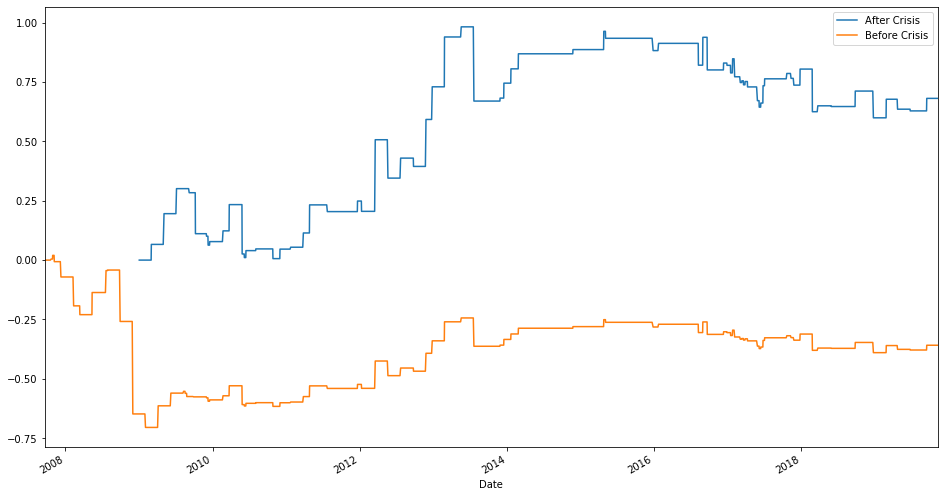

In [58]:
results_09['Real_Return'].plot(label='After Crisis')
results_07['Real_Return'].plot(label='Before Crisis')
plt.legend()
plt.show()

In [53]:
sharpe_07 =  results_07['Unreal_Return'].mean()/results_09['Unreal_Return'].std()
print('Sharpe Ratio each day:', sharpe_07)
print('Sharpe Ratio each year:', sharpe_07 * np.sqrt(251))

Sharpe Ratio each day: 0.017015363771852025
Sharpe Ratio each year: 0.2695740597245997
